## Optical Oscilloscope: Real-time filtering
---

This is the Jupyter Notebook for implementing my filtering algorithm with different parameters as well as comparison of the results with previously processed data.

### Imports

In [1]:
import numpy as np
import tifffile as tf
import matplotlib.pyplot as plt
import pandas as pd
import multiprocessing
from scipy import ndimage
from collections import deque

#### Load and display the stack

In [2]:
file_path = 'data_from_paper.ome.tif'
stack = tf.imread(file_path)

Display the original image and a couple regions of interest that we will be working on. 

Text(0.5, 1.0, 'Cell 18')

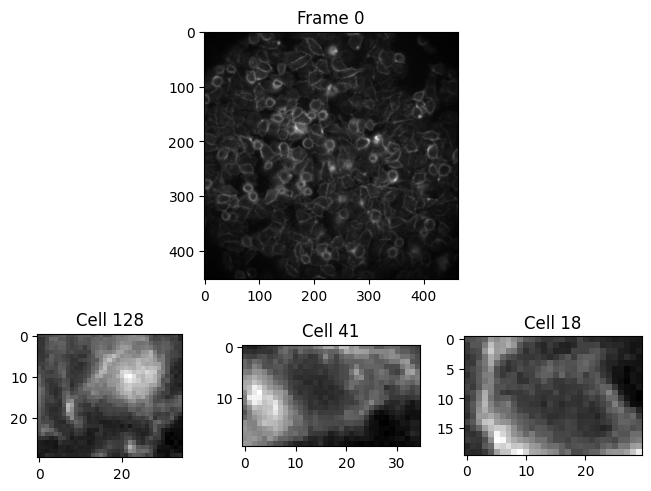

In [3]:
axd = plt.figure(layout='constrained').subplot_mosaic(
'''
AAA
BCD
''',
height_ratios=[2, 1],
width_ratios=[1, 1, 1]
)

axd['A'].imshow(stack[0, :, :], cmap='gray')
axd['A'].set_title('Frame 0')
axd['B'].imshow(stack[0, 235:265, 240:275], cmap='gray') # Cell 128
axd['B'].set_title('Cell 128')
axd['C'].imshow(stack[0, 95:115, 235:270], cmap='gray') # Cell 41
axd['C'].set_title('Cell 41')
axd['D'].imshow(stack[0, 50:70, 230:260], cmap='gray') # Cell 18
axd['D'].set_title('Cell 18')

## Algorithm Implementation

### Function definition

In [99]:
def filtering(x1, x2, y1, y2, batch_size):
    total_indices = len(stack) # stack is a global variable
    num_batches = total_indices // batch_size + (1 if total_indices % batch_size != 0 else 0)
    origin = (1000//2 - 1)
    raw_time_series = np.fromiter((np.mean(stack[i, x1:x2, y1:y2]) for i in range(len(stack))), dtype=float)
    result_data = []
    time_delays = []

    for batch_idx in range(num_batches):
        start_index = batch_idx * batch_size
        end_index = min((batch_idx + 1) * batch_size, total_indices)
        result_data_batch = np.zeros((end_index // 2) + 1)

        for index in range(start_index, end_index, 2):
            
            blue = raw_time_series[:index:2].astype(float)
            green = raw_time_series[1:index:2].astype(float)
            blue /= ndimage.uniform_filter(blue, size=1000, mode='nearest', # Need to QUANTIFY analytically how it could be similar
                                            origin=origin)
            green /= ndimage.uniform_filter(green, size=1000, mode='nearest', # Need to QUANTIFY analytically how it could be similar
                                            origin=origin)
            frame = blue/green
            idx = int(index / 2)
            if frame.size != 0:
                result_data_batch[idx] = frame[idx-1]
        result_data.append(result_data_batch)
    return result_data

In [179]:
def filtering_ma(x1, x2, y1, y2, batch_size):
    total_indices = len(stack) # stack is a global variable
    num_batches = total_indices // batch_size + (1 if total_indices % batch_size != 0 else 0)
    origin = (1000//2 - 1)
    raw_time_series = np.fromiter((np.mean(stack[i, x1:x2, y1:y2]) for i in range(len(stack))), dtype=float)
    result_data = []
    time_delays = []

    for batch_idx in range(num_batches):
        start_index = batch_idx * batch_size
        end_index = min((batch_idx + 1) * batch_size, total_indices)
        result_data_batch = np.zeros((end_index // 2) + 1)

        for index in range(start_index, end_index, 2):
            blue = raw_time_series[:index:2].astype(float)
            green = raw_time_series[1:index:2].astype(float)
            blue /= ndimage.uniform_filter(blue, size=1000, mode='nearest', # Need to QUANTIFY analytically how it could be similar
                                            origin=origin)
            green /= ndimage.uniform_filter(green, size=1000, mode='nearest', # Need to QUANTIFY analytically how it could be similar
                                            origin=origin)
            frame = blue/green
            frame_series = pd.Series(frame)
            windows = frame_series.rolling(10)
            ma = windows.mean()
            ma_list = ma.to_list()
            idx = int(index / 2)
            if ma_list:
                result_data_batch[idx] = ma_list[idx-1]
        result_data.append(result_data_batch)
    return result_data

In [349]:
def filtering_ma_tup(tup):
    x1, x2, y1, y2, batch_size = tup
    total_indices = len(stack) # stack is a global variable
    num_batches = total_indices // batch_size + (1 if total_indices % batch_size != 0 else 0)
    origin = (1000//2 - 1)
    raw_time_series = np.fromiter((np.mean(stack[i, x1:x2, y1:y2]) for i in range(len(stack))), dtype=float)
    result_data = []
    time_delays = []

    for batch_idx in range(num_batches):
        start_index = batch_idx * batch_size
        end_index = min((batch_idx + 1) * batch_size, total_indices)
        result_data_batch = np.zeros((end_index // 2) + 1)

        for index in range(start_index, end_index, 2):
            blue = raw_time_series[:index:2].astype(float)
            green = raw_time_series[1:index:2].astype(float)
            blue /= ndimage.uniform_filter(blue, size=1000, mode='nearest', # Need to QUANTIFY analytically how it could be similar
                                            origin=origin)
            green /= ndimage.uniform_filter(green, size=1000, mode='nearest', # Need to QUANTIFY analytically how it could be similar
                                            origin=origin)
            frame = blue/green
            frame_series = pd.Series(frame)
            windows = frame_series.rolling(10)
            ma = windows.mean()
            ma_list = ma.to_list()
            idx = int(index / 2)
            if ma_list:
                result_data_batch[idx] = ma_list[idx-1]
        result_data.append(result_data_batch)
    return result_data

In [307]:
import time

def filtering_ma_time(x1, x2, y1, y2, batch_size):
    total_indices = len(stack) # stack is a global variable
    num_batches = total_indices // batch_size + (1 if total_indices % batch_size != 0 else 0)
    origin = (1000//2 - 1)
    raw_time_series = np.fromiter((np.mean(stack[i, x1:x2, y1:y2]) for i in range(len(stack))), dtype=float)
    result_data = []
    time_delays = []

    for batch_idx in range(num_batches):
        start_index = batch_idx * batch_size
        end_index = min((batch_idx + 1) * batch_size, total_indices)
        result_data_batch = np.zeros((end_index // 2) + 1)

        for index in range(start_index, end_index, 2):
            start = time.time()
            blue = raw_time_series[:index:2].astype(float)
            green = raw_time_series[1:index:2].astype(float)
            blue /= ndimage.uniform_filter(blue, size=1000, mode='nearest', # Need to QUANTIFY analytically how it could be similar
                                            origin=origin)
            green /= ndimage.uniform_filter(green, size=1000, mode='nearest', # Need to QUANTIFY analytically how it could be similar
                                            origin=origin)
            frame = blue/green
            frame_series = pd.Series(frame)
            windows = frame_series.rolling(10)
            ma = windows.mean()
            ma_list = ma.to_list()
            idx = int(index / 2)
            if ma_list:
                result_data_batch[idx] = ma_list[idx-1]
                end = time.time()
                time_delays.append((end - start) * 10**3)
        result_data.append(result_data_batch)
    return result_data, time_delays

In [274]:
def nofiltering(x1, x2, y1, y2):
    raw_time_series = np.fromiter((np.mean(stack[i, x1:x2, y1:y2]) for i in range(len(stack))), dtype=float)
    blue = raw_time_series[::2].astype(float)
    green = raw_time_series[1::2].astype(float)
    frames = blue/green
    return frames

### Prepare figures

First, prepare figures of previously acquired/filtered data.

In [85]:
df_y_filtered = pd.read_csv('fig_3__3A_y_filtered.txt', sep=' ', header=None)
y_axis_filtered = df_y_filtered.iloc[10] # Choose cell on previously filtered data
df_x = pd.read_csv('fig_3__3A_x.txt', sep=' ', header=None)
df_y = pd.read_csv('fig_3__3A_y.txt', sep=' ', header=None) # Unfiltered
y_axis = df_y.iloc[10] 

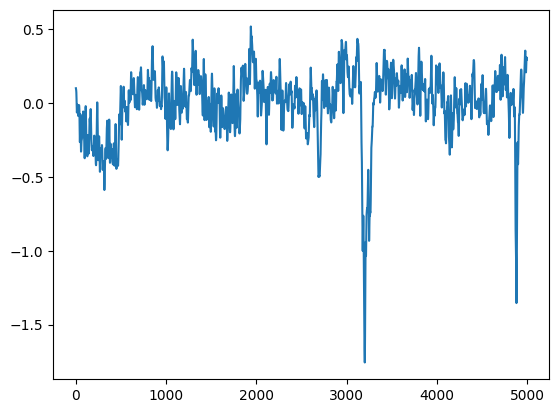

In [287]:
plt.plot(y_axis)
plt.show()

Code for implementing the new filtering algorithm on selected cells

In [158]:
# Cell locations
row_tuples = [(235, 265), (95, 115), (50, 70)]
col_tuples = [(240, 275), (235, 270), (230, 260)]

In [199]:
def workflow(rowtup, coltup):
    (x1, x2) = rowtup
    (y1, y2) = coltup
    result_data = filtering_ma(x1, x2, y1, y2, 100)
    for i in range(len(result_data)):
        result_data[i] = result_data[i][result_data[i] != 0]
    result_data = np.concatenate(result_data)
    return result_data

In [275]:
def workflow_nf(rowtup, coltup):
    (x1, x2) = rowtup
    (y1, y2) = coltup
    data_nf = nofiltering(x1, x2, y1, y2)
    return data_nf

In [206]:
# Store previously acquired data for plotting
cell_ids = [10, 13, 14]
previous_processed = []
for id in cell_ids:
    y_axis = df_y_filtered.iloc[id]
    previous_processed.append(y_axis[9:])

In [288]:
# Store previously acquired data for plotting
cell_ids = [10, 13, 14]
no_filter_pp = []
for id in cell_ids:
    y_axis = df_y.iloc[id]
    no_filter_pp.append(y_axis[9:])

In [201]:
current_processed = []
for i in range(3):
    result_tseries = workflow(row_tuples[i], col_tuples[i])
    current_processed.append(result_tseries)

In [278]:
no_filter = []
for i in range(3):
    result_tseries = workflow_nf(row_tuples[i], col_tuples[i])
    no_filter.append(result_tseries[:-10])

In [270]:
divergent_points_pp = []
for i in range(3):
    mn = np.mean(previous_processed[i][1000:])
    std = np.std(previous_processed[i][1000:])
    threshold = 2.5 * std
    divergent_points_pp.append(np.abs(previous_processed[i][1000:] - mn) > threshold)

In [ ]:
divergent_points = []
for i in range(3):
    mn = np.mean(current_processed[i][1000:])
    std = np.std(current_processed[i][1000:])
    threshold = 2.5 * std
    divergent_points.append(np.abs(current_processed[i][1000:] - mn) > threshold)

In [265]:
time = np.arange(len(current_processed[0]))

In [271]:
time_pp = np.arange(len(previous_processed[0]))

In [ ]:
snr_pp_list = []
snr_cp_list = []
snr_pp_list_db = []
snr_cp_list_db = []

for i in range(3):
    noise_pp = no_filter_pp[i] - previous_processed[i]
    noise_cp = no_filter[i][1000:] - current_processed[i][1000:]
    sp_pp = np.mean(previous_processed[i][1000:] ** 2)
    np_pp = np.mean(noise_pp ** 2)
    sp_cp = np.mean(current_processed[i][1000:] ** 2)
    np_cp = np.mean(noise_cp ** 2)
    snr_pp = sp_pp / np_pp
    snr_cp = sp_cp / np_cp
    snr_pp_db = 10 * np.log10(snr_pp)
    snr_cp_db = 10 * np.log10(snr_cp)
    snr_pp_list.append(snr_pp)
    snr_pp_list_db.append(snr_pp_db)
    snr_cp_list.append(snr_cp)
    snr_cp_list_db.append(snr_cp_db)

In [302]:
snr_cp_list_db

[46.989180774075365, 36.197171962325484, 43.201828234636004]

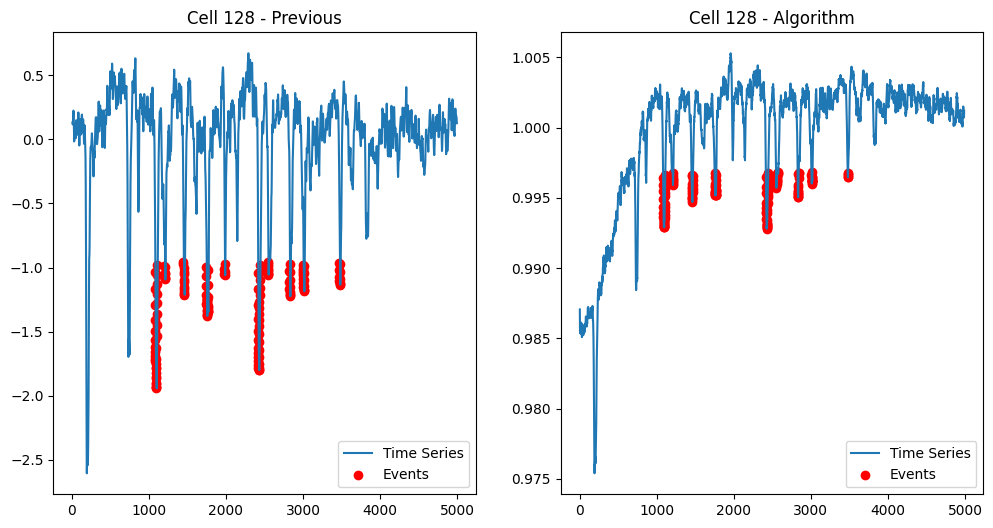

In [272]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(previous_processed[0], label='Time Series')
ax1.scatter(time_pp[1000:][divergent_points_pp[0]], previous_processed[0][1000:][divergent_points_pp[0]], color='red', marker='o', label='Events')
ax1.set_title('Cell 128 - Previous')
ax1.legend()
ax2.plot(current_processed[0], label='Time Series')
ax2.scatter(time[1000:][divergent_points[0]], current_processed[0][1000:][divergent_points[0]], color='red', marker='o', label='Events')
ax2.set_title('Cell 128 - Algorithm')
ax2.legend()

Text(0.5, 1.0, 'Cell 18 - Algorithm')

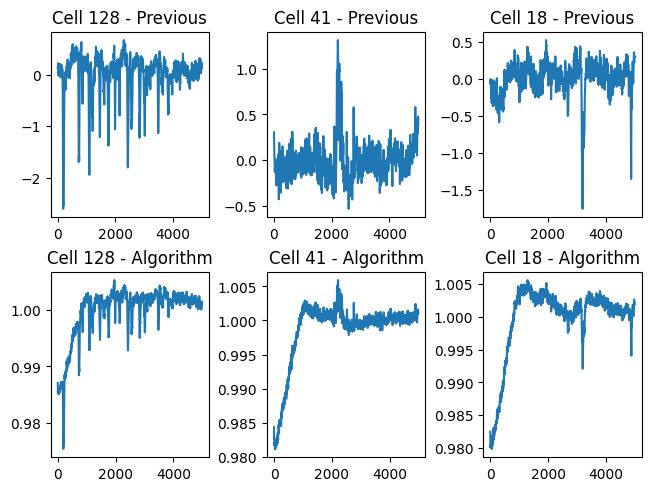

In [273]:
axd = plt.figure(layout='constrained').subplot_mosaic(
'''
ABC
DEF
''',
height_ratios=[1, 1],
width_ratios=[1, 1, 1]
)

axd['A'].plot(previous_processed[0])
axd['A'].set_title('Cell 128 - Previous')
axd['B'].plot(previous_processed[1])
axd['B'].set_title('Cell 41 - Previous')
axd['C'].plot(previous_processed[2])
axd['C'].set_title('Cell 18 - Previous')
axd['D'].plot(current_processed[0])
axd['D'].set_title('Cell 128 - Algorithm')
axd['E'].plot(current_processed[1])
axd['E'].set_title('Cell 41 - Algorithm')
axd['F'].plot(current_processed[2])
axd['F'].set_title('Cell 18 - Algorithm')

In [345]:
import itertools
iterable = itertools.repeat((235, 265, 240, 275), 100)
def iterfun(tup):
    (x1, x2, y1, y2) = tup
    _, time_delays = filtering_ma_time(x1, x2, y1, y2, 100)
    return time_delays
time_delays_array = np.array(list(map(iterfun, iterable)))
time_delays_mn = np.mean(time_delays_array, axis=0)

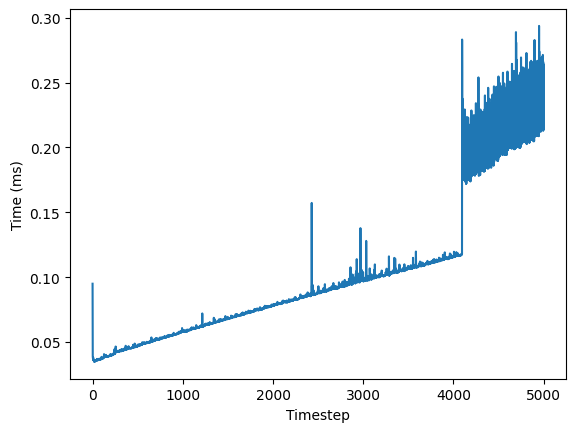

In [347]:
fig, ax = plt.subplots()
ax.plot(time_delays_mn)
ax.set_ylabel('Time (ms)')
ax.set_xlabel('Timestep')
plt.show()

In [368]:
def itercell(iterable):
    start = time.time()
    result_data = list(map(filtering_ma_tup, iterable))
    end = time.time()
    elapsed = (end - start) * 10 ** 6
    return elapsed

def iter_able(num_cells):
    iterable = itertools.repeat((235, 265, 240, 275, 100), num_cells)
    elapsed = itercell(iterable)
    return elapsed

time_elapsed = list(map(iter_able, range(1, 11)))

In [370]:
time_elapsed_ms = [time / (10 ** 3) for time in time_elapsed]
time_elapsed_ms

[730.9789657592773,
 1050.309181213379,
 1798.7728118896484,
 2428.9731979370117,
 2525.094985961914,
 3055.7777881622314,
 3517.362117767334,
 4310.732126235962,
 4841.4411544799805,
 5403.414964675903]

Text(0.5, 0, 'Number of cells')

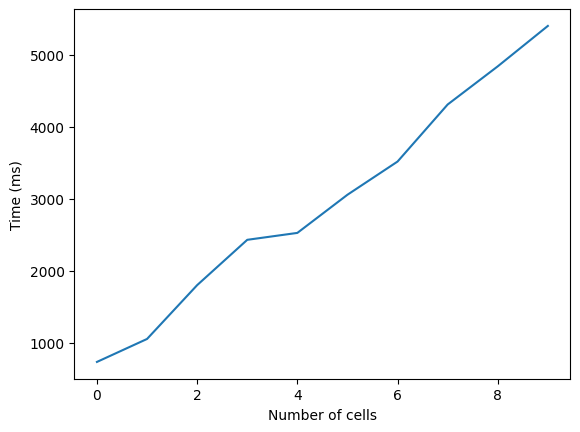

In [372]:
fig, ax = plt.subplots()
ax.plot(range(len(time_elapsed_ms)), time_elapsed_ms)
ax.set_ylabel('Time (ms)')
ax.set_xlabel('Number of cells')